In [2]:
import inspect
from finta import TA
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix
from sklearn.preprocessing import PolynomialFeatures
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import cross_validate
from sklearn.pipeline import Pipeline
from sklearn.svm import SVC

from process_data.plot_prediction import plot_prediction

from yellowbrick.classifier import ConfusionMatrix
from sklearn.decomposition import PCA
from sklearn.metrics import classification_report, confusion_matrix , accuracy_score

In [392]:
# Load S&P 500 Data
spy_all = pd.read_pickle('clean_data/spy_all.pkl')
spy_all.reset_index(inplace=True)

### Logistic Regression

In [328]:
X_poly=pd.concat([X.loc[:,'30 period CCI_30':"MFV_"], X.loc[:,'30 period CCI_30_sandp':]], axis=1)
X_dummy=X.loc[:,'state_AL':'idbflag_D']
X_Normal=X.drop((list(X_poly.columns)+list(X_dummy.columns)), axis=1)

In [329]:
poly = PolynomialFeatures(degree=3)
Xp = poly.fit_transform(X_poly)

In [330]:
X_to_scale=pd.concat([pd.DataFrame(Xp),X_Normal], axis=1)

In [331]:
sd = StandardScaler()
X_scaled=sd.fit_transform(X_to_scale)

In [332]:
X_joined=pd.concat([pd.DataFrame(X_scaled), X_dummy], axis=1)

In [336]:
X_train, X_test, y_train, y_test = train_test_split(X_joined, y, test_size = 0.2)

In [528]:
clf = LogisticRegression(n_jobs=-1, solver='lbfgs').fit(X_train, y_train)
clf.score(X_train, y_train)
clf.score(X_test, y_test)
y_pred = clf.predict(X_test)
pred_all = clf.predict(X_joined)

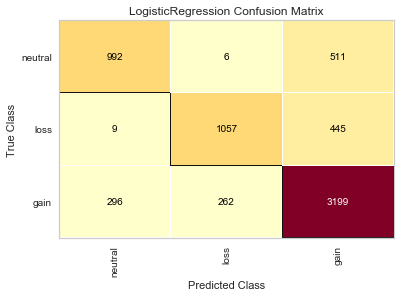

In [343]:
cm = ConfusionMatrix(clf, classes=['neutral', 'loss', 'gain'])
cm.fit(X_train, y_train)
cm.score(X_test, y_test)
cm.poof();

### Plot results

In [645]:
spy_all_agg_gain = spy_all.groupby('date')[['return_by_action_gain','share_price_in_action_gain']].sum()
spy_all_agg_gain['dollar_return_gain_only']=spy_all_agg_gain['return_by_action_gain']/spy_all_agg_gain['share_price_in_action_gain']
spy_all_agg = spy_all.groupby('date')[['return_by_action','share_price_in_action']].sum()
spy_all_agg['dollar_return']=spy_all_agg['return_by_action']/spy_all_agg['share_price_in_action']
spy_all_agg['no_reinvest_cumsum']=spy_all_agg['dollar_return'].cumsum()

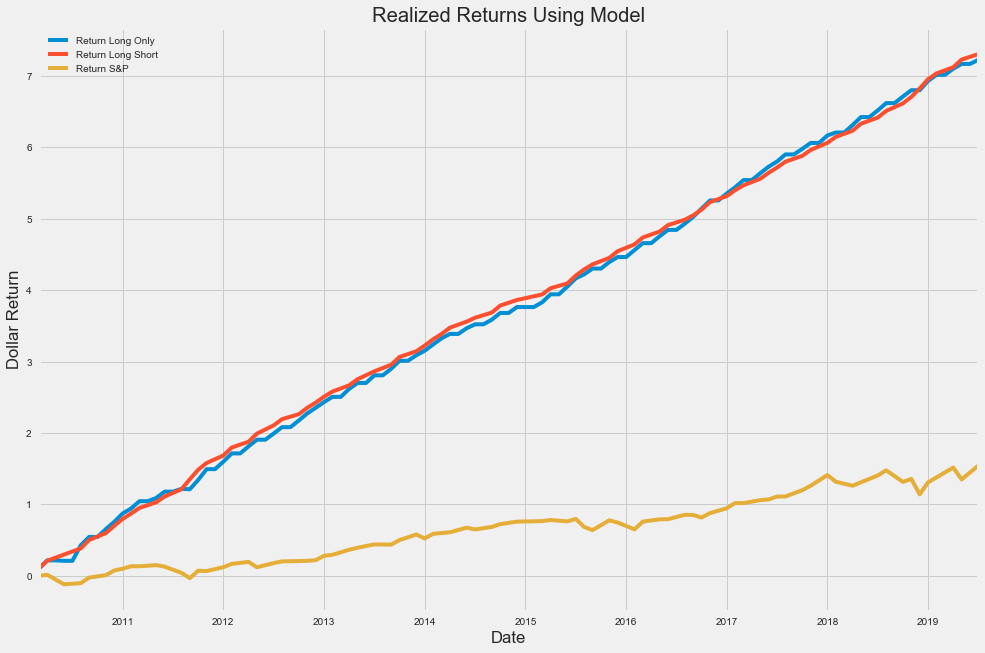

In [668]:
spy_all_agg_gain.dollar_return_gain_only.asfreq('m').fillna(0).cumsum().plot.line(figsize=(15, 10), label='Return Long Only')
spy_all_agg.no_reinvest_cumsum.plot.line(figsize=(15, 10), label='Return Long Short')
ax = spy_all_agg_sp.sp_return.plot.line(figsize=(15, 10), label='Return S&P')
ax.set_title('Realized Returns Using Model')
ax.set_ylabel('Dollar Return')
ax.set_xlabel('Date')
ax.legend()
filename = str(ax.get_title()).replace(' ', '_')
plt.savefig('../visualizations/{}.png'.format(filename),
           transparent=True,)

### When the model goes wrong

In [693]:
predict_gain=spy_all[spy_all['predicted_class']=='gain']

In [ ]:
predict_gain['spot_off']=(predict_gain['roi_class']!='gain').astype(int)

In [710]:
spot_off_series=predict_gain.groupby('date')['spot_off'].mean().asfreq('m').fillna(0)

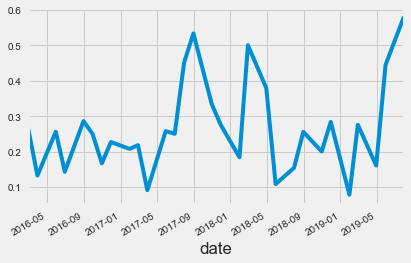

In [715]:
spot_off_series[spot_off_series!=0][-30:].plot()

In [503]:
tic_predict = pd.merge(spy_all, pred_df, how='left', left_index=True, right_index=True)
tic = 'MSFT'
aapl_pred = tic_predict.loc[tic_predict.tic == tic].copy()
aapl_pred = aapl_pred.set_index('date').sort_index()
aapl_pred.loc[aapl_pred.predicted_class != aapl_pred.roi_class_y].dropna()

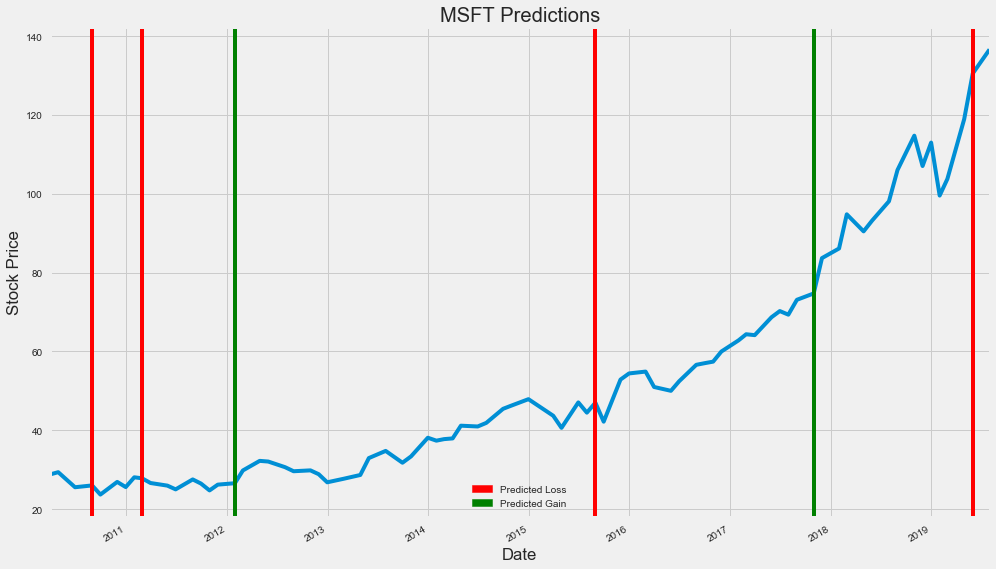

In [484]:
plot_prediction(aapl_pred)

### Random Forest 

In [345]:
rfc = RandomForestClassifier(n_estimators=200, max_features= 'auto', max_depth=10,  oob_score=True)
cv = cross_validate(rfc, X_joined, y,return_estimator= True, cv=None, n_jobs=-1)

In [346]:
cv['test_score']

array([0.68685259, 0.68950863, 0.70987162])

In [347]:
est_list = [est for est in cv['estimator']]

In [348]:
[est.oob_score_ for est in est_list]

[0.7751217352810978, 0.7839309428950864, 0.783842408145197]

### SVC

In [55]:
poly = PolynomialFeatures(degree=2)
Xp = poly.fit_transform(X.loc[:, '30 period CCI_30':'MFV_'])
Xrest=X.loc[:, 'acchgq':]
Xp = pd.DataFrame(Xp)
Xrest.reset_index(inplace=True)
X_poly = pd.concat([Xrest, Xp], axis=1)
X_train, X_test, y_train, y_test = train_test_split(X_poly, y, test_size = 0.2)

In [56]:
sd = StandardScaler()
X_train = sd.fit_transform(X_train)
X_test = sd.fit_transform(X_test)

In [244]:
svclassifier = SVC(kernel='rbf', C=1)
svclassifier.fit(X_train, y_train)

/Users/flatironschool/anaconda3/envs/learn-env/lib/python3.6/site-packages/sklearn/svm/base.py:193: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)


SVC(C=1, cache_size=200, class_weight=None, coef0=0.0,
    decision_function_shape='ovr', degree=3, gamma='auto_deprecated',
    kernel='rbf', max_iter=-1, probability=False, random_state=None,
    shrinking=True, tol=0.001, verbose=False)

In [245]:
y_pred = svclassifier.predict(X_test)

In [246]:
print(confusion_matrix(y_test, y_pred) )  
print(classification_report(y_test, y_pred)) 
print(f"The accuracy score is {accuracy_score(y_test, y_pred)}")

[[1226    8  935]
 [   8 1220  900]
 [ 358  322 4572]]
              precision    recall  f1-score   support

        gain       0.77      0.57      0.65      2169
        loss       0.79      0.57      0.66      2128
     neutral       0.71      0.87      0.78      5252

    accuracy                           0.73      9549
   macro avg       0.76      0.67      0.70      9549
weighted avg       0.74      0.73      0.73      9549

The accuracy score is 0.734946067651063
